In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
df = pd.read_csv('data/sbux.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
1,2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2,2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
3,2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
4,2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900


스타벅스 주가 데이터 
- Date : 날짜 
- Open : 오픈가 
- High : 최고가
- Low : 최저가
- Close : 종가
- Adj Close : 
- Volume :  거래량

# Data Preprocessing

## Date column을 DateTime형식으로 변경

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Volume'] = df['Volume'].astype(float)

In [5]:
x_cols = ['Open','High','Low','Close','Adj Close']
y_cols = ['Volume']
df_x = df[x_cols]
df_y = df[y_cols]

In [6]:
df_x

,Open,High,Low,Close,Adj Close
0,86.260002,86.870003,85.849998,86.589996,84.145752
1,88.000000,88.889999,87.540001,88.209999,85.720032
2,88.019997,88.790001,87.580002,88.669998,86.167046
3,89.139999,89.300003,88.430000,88.779999,86.273941
4,88.870003,88.970001,87.470001,88.129997,85.642288
...,...,...,...,...,...
248,101.349998,102.940002,101.070000,102.279999,101.442787
249,102.010002,102.220001,100.690002,101.410004,100.579918
250,100.370003,101.570000,100.010002,101.209999,100.381554
251,101.940002,102.209999,100.099998,100.400002,99.578186


In [7]:
df_y.head()

,Volume
0,4921900.0
1,10282100.0
2,6714100.0
3,6705600.0
4,7296900.0


## Data Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


정규화 진행 

In [9]:
scaler = StandardScaler()
scaler.fit(df_x)
x = scaler.transform(df_x)

scaler = MinMaxScaler()
scaler.fit(df_y)
y = scaler.transform(df_y)

학습,평가 데이터 구분 

In [10]:
x_trn, x_tst = x[:200,:], x[200:,:]
y_trn, y_tst = y[:200,:], y[200:,:]

In [11]:
x_trn, y_trn = torch.Tensor(x_trn), torch.Tensor(y_trn)
x_tst, y_tst = torch.Tensor(x_tst), torch.Tensor(y_tst)

## Tensor의 shape변경
### (data_size, num_columns) --> (data_size, seq_len, num_columns)

In [12]:
x_trn = torch.unsqueeze(x_trn, 1) # x_trn = torch.reshape(x_trn, (x_trn.shape[0], 1, x_trn.shape[1]))
x_tst = torch.unsqueeze(x_tst, 1) # x_tst = torch.reshape(x_trn, (x_tst.shape[0], 1, x_tst.shape[1]))

In [13]:
print(x_trn.shape, x_tst.shape)

torch.Size([200, 1, 5]) torch.Size([53, 1, 5])


In [14]:
print(y_trn.shape, y_tst.shape)

torch.Size([200, 1]) torch.Size([53, 1])


# Modeling

In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

![fig1](imgs/figure1.png)

- <span style = 'font-size:1.3em;line-height:1.5em'>x1, x2, ..., xn에 매 time의 ['Open','High','Low','Close','AdjClose']을 입력</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>즉, 매 x는 5차원의 data이고, seq의 길이는 200인 multivarite time series data 한개를 입력</span>
- <span style = 'font-size:1.3em;line-height:1.5em'>y1, y2, ..., yn에 매 time의 ['Volume']을 입력</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>즉, 매 y는 1차원의 data이고, seq의 길이는 200인 univariate time series data 한개를 입력</span>

## 1. Define Model Structure

### (1) RNN

In [47]:
class MyRNN(nn.Module):
    def __init__(self, n_classes, input_size, hidden_size, num_layers, seq_len):
        super(MyRNN, self).__init__()
        self.n_classes = n_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size=self.input_size, 
                          hidden_size=self.hidden_size, 
                          num_layers=self.num_layers, 
                          batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size, 128)
        self.fc2 = nn.Linear(128, self.n_classes)
        
    def forward(self, x):
        h0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)) # 계층수, 배치, 히든 dim
        print('ho: ',h0.shape)
        output, hn = self.rnn(x, h0)
        print('out: ',output.shape)
        print('hn: ',hn.shape)
        hn = hn.view(-1, self.hidden_size)
        
        out = F.relu(hn)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

### (2) LSTM

In [48]:
class MyLSTM(nn.Module):
    def __init__(self, n_classes, input_size, hidden_size, num_layers, seq_len):
        super(MyLSTM, self).__init__()
        self.n_classes = n_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, 
                            batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size, 128)
        self.fc2 = nn.Linear(128, self.n_classes)
    
    def forward(self, x):
        # cell state, hidden state 초기화
        h0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)) # hidden state 0으로 초기화
        c0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)) # cell state 0으로 초기화
        
        # lstm돌아가는 부분
        output, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn.view(-1, self.hidden_size)
        
        # 매 step마다 
        out = F.relu(hn)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out
        

### (3) GRU

In [49]:
class MyGRU(nn.Module):
    def __init__(self, n_classes, input_size, hidden_size, num_layers, seq_len):
        super(MyGRU, self).__init__()
        self.n_classes = n_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.gru = nn.GRU(input_size=self.input_size, 
                          hidden_size=self.hidden_size,
                          num_layers=self.num_layers, 
                          batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size, 128)
        self.fc2 = nn.Linear(128, self.n_classes)
        
    def forward(self, x):
        h0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)) # hidden state 0으로 초기화
        output, (hn) = self.gru(x, (h0))
        hn = hn.view(-1, self.hidden_size)

        out = F.relu(hn)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

## 2. Train model

In [50]:
num_epochs = 1000
lr = 0.0001

input_size = 5 # Input data에는 총 5개의 column
hidden_size = 5 # hidden layer의 neuron 수
num_layers = 1 # LSTM 계층의 수

n_classes = 1
loss_func = nn.MSELoss()

### (1) RNN

In [51]:
model_rnn = MyRNN(n_classes=n_classes, 
                  input_size=input_size, 
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  seq_len = x_trn.shape[1])
rnn_opt = optim.Adam(params = model_rnn.parameters(), lr = lr)

In [22]:
for epoch in range(num_epochs):
    output = model_rnn.forward(x_trn)
    rnn_opt.zero_grad()
    loss = loss_func(output, y_trn)
    loss.backward()
    rnn_opt.step()
    if (epoch+1) % 100 == 0:
        print(f'In epoch {epoch+1}, loss={loss.item():.4f}')

In epoch 100, loss=0.0404
In epoch 200, loss=0.0306
In epoch 300, loss=0.0264
In epoch 400, loss=0.0240
In epoch 500, loss=0.0223
In epoch 600, loss=0.0210
In epoch 700, loss=0.0199
In epoch 800, loss=0.0192
In epoch 900, loss=0.0185
In epoch 1000, loss=0.0180


In [52]:
model = MyRNN(n_classes=n_classes, 
                  input_size=input_size, 
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  seq_len = x_trn.shape[1])

In [53]:
out = model(x_trn)
out.shape

ho:  torch.Size([1, 200, 5])
out:  torch.Size([200, 1, 5])
hn:  torch.Size([1, 200, 5])


torch.Size([200, 1])

### (2) LSTM

In [23]:
model_lstm = MyLSTM(n_classes=n_classes, 
                    input_size=input_size, 
                    hidden_size=hidden_size, 
                    num_layers=num_layers, 
                    seq_len=x_trn.shape[1])

lstm_opt = optim.Adam(params = model_lstm.parameters(), lr = lr)

In [24]:
for epoch in range(num_epochs):
    output = model_lstm.forward(x_trn)
    lstm_opt.zero_grad()
    loss = loss_func(output, y_trn)
    loss.backward()
    lstm_opt.step()
    if (epoch+1) % 100 == 0:
        print(f'In epoch {epoch+1}, loss={loss.item():.4f}')

In epoch 100, loss=0.0414
In epoch 200, loss=0.0389
In epoch 300, loss=0.0378
In epoch 400, loss=0.0357
In epoch 500, loss=0.0339
In epoch 600, loss=0.0332
In epoch 700, loss=0.0328
In epoch 800, loss=0.0322
In epoch 900, loss=0.0314
In epoch 1000, loss=0.0306


### (3) GRU

In [25]:
model_gru = MyGRU(n_classes=n_classes, 
                  input_size=input_size, 
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  seq_len=x_trn.shape[1])

gru_opt = optim.Adam(params=model_gru.parameters(), lr=lr)

In [26]:
for epoch in range(num_epochs):
    output = model_gru.forward(x_trn)
    gru_opt.zero_grad()
    loss = loss_func(output, y_trn)
    loss.backward()
    gru_opt.step()
    if (epoch+1) % 100 == 0:
        print(f'In epoch {epoch+1}, loss={loss.item():.4f}')

In epoch 100, loss=0.1581
In epoch 200, loss=0.0782
In epoch 300, loss=0.0480
In epoch 400, loss=0.0365
In epoch 500, loss=0.0311
In epoch 600, loss=0.0283
In epoch 700, loss=0.0267
In epoch 800, loss=0.0254
In epoch 900, loss=0.0241
In epoch 1000, loss=0.0227


## 3. 결과 plottting해보기

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

### (1) prediction하기 - RNN

In [28]:
scaler = StandardScaler()
scaler.fit(df_x)
x = scaler.transform(df_x)

scaler = MinMaxScaler()
scaler.fit(df_y)
y = scaler.transform(df_y)

x, y = torch.Tensor(x), torch.Tensor(y)
x = torch.unsqueeze(x, 1) # x_trn = torch.reshape(x_trn, (x_trn.shape[0], 1, x_trn.shape[1]))

In [29]:
y_pred = model_rnn.forward(x)

#### torch Tensor --> numpy array

In [30]:
y = y.detach().cpu().numpy()
y_pred = y_pred.detach().cpu().numpy()

#### 원래 scale로 되돌리기

In [31]:
y = scaler.inverse_transform(y)
y_pred = scaler.inverse_transform(y_pred)

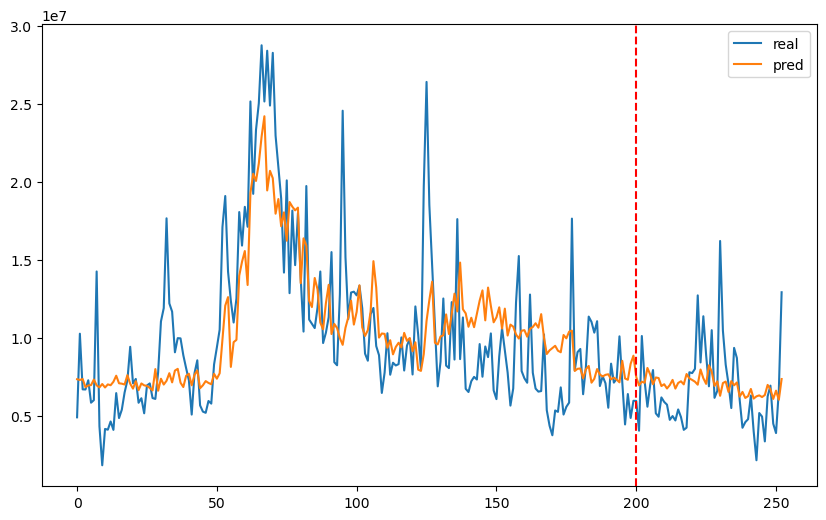

In [32]:
plt.figure(figsize=(10,6))
plt.plot(y)
plt.plot(y_pred)
plt.axvline(x=200, c='r', linestyle='--') 
plt.legend(['real', 'pred'])

### (2) prediction하기 - LSTM

In [33]:
scaler = StandardScaler()
scaler.fit(df_x)
x = scaler.transform(df_x)

scaler = MinMaxScaler()
scaler.fit(df_y)
y = scaler.transform(df_y)

x, y = torch.Tensor(x), torch.Tensor(y)
x = torch.unsqueeze(x, 1) # x_trn = torch.reshape(x_trn, (x_trn.shape[0], 1, x_trn.shape[1]))

In [34]:
y_pred = model_lstm.forward(x)

#### torch Tensor --> numpy array

In [35]:
y = y.detach().cpu().numpy()
y_pred = y_pred.detach().cpu().numpy()

In [36]:
y = scaler.inverse_transform(y)
y_pred = scaler.inverse_transform(y_pred)

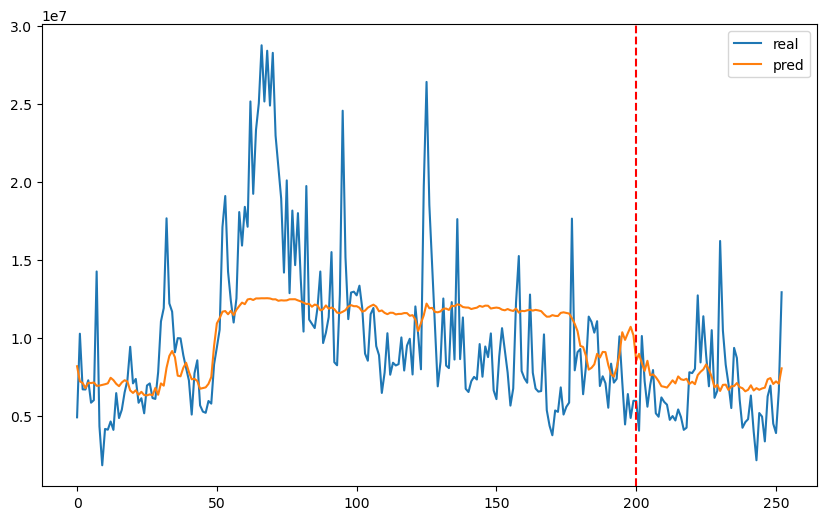

In [37]:
plt.figure(figsize=(10,6))
plt.plot(y)
plt.plot(y_pred)
plt.axvline(x=200, c='r', linestyle='--') 
plt.legend(['real', 'pred'])

### (3) prediction하기 - GRU

In [38]:
scaler = StandardScaler()
scaler.fit(df_x)
x = scaler.transform(df_x)

scaler = MinMaxScaler()
scaler.fit(df_y)
y = scaler.transform(df_y)

x, y = torch.Tensor(x), torch.Tensor(y)
x = torch.unsqueeze(x, 1) # x_trn = torch.reshape(x_trn, (x_trn.shape[0], 1, x_trn.shape[1]))

In [39]:
y_pred = model_gru.forward(x)

In [40]:
y = y.detach().cpu().numpy()
y_pred = y_pred.detach().cpu().numpy()

In [41]:
y = scaler.inverse_transform(y)
y_pred = scaler.inverse_transform(y_pred)

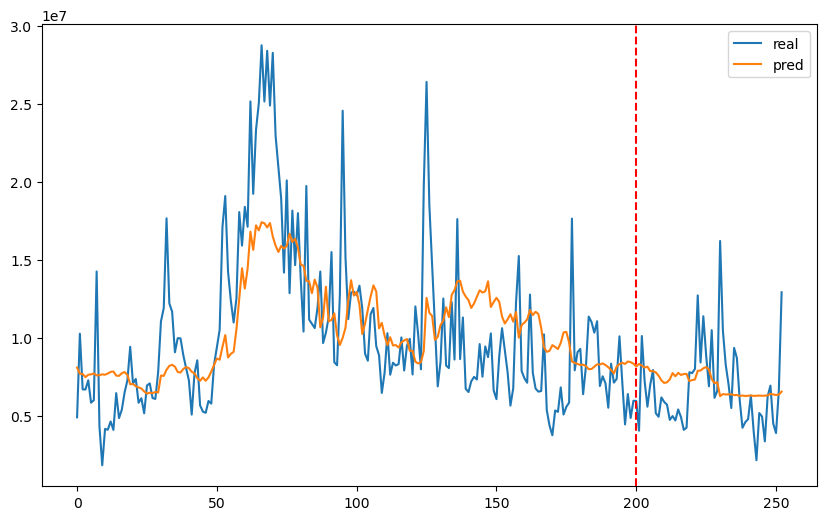

In [42]:
plt.figure(figsize=(10,6))
plt.plot(y)
plt.plot(y_pred)
plt.axvline(x=200, c='r', linestyle='--') 
plt.legend(['real', 'pred'])

# Practice

<span style = 'font-size:1.3em;line-height:1.5em'>1.거래량 말고 종가를 예측해봅시다. </span>

- <span style = 'font-size:1.2em;line-height:1.5em'>학습 X: df의 index 0부터 199까지의 200일치 ['Open','High','Low','Close','Volume']</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>학습 Y: df의 index 0부터 199까지의 200일치 ['Close']</span>

- <span style = 'font-size:1.2em;line-height:1.5em'>학습 X: df의 index 200부터 252까지의 53일치 ['Open','High','Low','Close','Volume']</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>학습 Y: df의 index 200부터 252까지의 53일치 ['Close']</span>


In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].astype(float)
x_cols = ['Open','High','Low','Volume']
y_cols = ['Close']
df_x = df[x_cols]
df_y = df[y_cols]

In [44]:
df_x

,Open,High,Low,Volume
0,86.260002,86.870003,85.849998,4921900.0
1,88.000000,88.889999,87.540001,10282100.0
2,88.019997,88.790001,87.580002,6714100.0
3,89.139999,89.300003,88.430000,6705600.0
4,88.870003,88.970001,87.470001,7296900.0
...,...,...,...,...
248,101.349998,102.940002,101.070000,6952700.0
249,102.010002,102.220001,100.690002,4514800.0
250,100.370003,101.570000,100.010002,3911300.0
251,101.940002,102.209999,100.099998,6629900.0


In [45]:
# 정규화
scaler = StandardScaler()
scaler.fit(df_x)
x = scaler.transform(df_x)

scaler = MinMaxScaler()
scaler.fit(df_y)
y = scaler.transform(df_y)

In [46]:
# train,test split
x_trn, x_tst = x[:200,:], x[200:,:]
y_trn, y_tst = y[:200,:], y[200:,:]

In [47]:
# numpy to tensor
x_trn, y_trn = torch.Tensor(x_trn), torch.Tensor(y_trn)
x_tst, y_tst = torch.Tensor(x_tst), torch.Tensor(y_tst)

In [48]:
x_trn = torch.unsqueeze(x_trn, 1) # x_trn = torch.reshape(x_trn, (x_trn.shape[0], 1, x_trn.shape[1]))
x_tst = torch.unsqueeze(x_tst, 1) # x_tst = torch.reshape(x_trn, (x_tst.shape[0], 1, x_tst.shape[1]))

In [49]:
num_epochs = 1000
lr = 0.0001

input_size = 4 # Input data에는 총 4개의 column
hidden_size = 5 # hidden layer의 neuron 수
num_layers = 1 # RNN 계층의 수

n_classes = 1
loss_func = nn.MSELoss()

In [50]:
# model & optimizer 
model_rnn = MyRNN(n_classes=n_classes, 
                  input_size=input_size, 
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  seq_len = x_trn.shape[1])
rnn_opt = optim.Adam(params = model_rnn.parameters(), lr = lr)

In [51]:
# train
for epoch in range(num_epochs):
    output = model_rnn.forward(x_trn)
    rnn_opt.zero_grad()
    loss = loss_func(output, y_trn)
    loss.backward()
    rnn_opt.step()
    if (epoch+1) % 100 == 0:
        print(f'In epoch {epoch+1}, loss={loss.item():.4f}')

In epoch 100, loss=0.2424
In epoch 200, loss=0.1050
In epoch 300, loss=0.0477
In epoch 400, loss=0.0241
In epoch 500, loss=0.0121
In epoch 600, loss=0.0058
In epoch 700, loss=0.0033
In epoch 800, loss=0.0023
In epoch 900, loss=0.0018
In epoch 1000, loss=0.0014


In [52]:
scaler = StandardScaler()
scaler.fit(df_x)
x = scaler.transform(df_x)

scaler = MinMaxScaler()
scaler.fit(df_y)
y = scaler.transform(df_y)

x, y = torch.Tensor(x), torch.Tensor(y)
x = torch.unsqueeze(x, 1) # x_trn = torch.reshape(x_trn, (x_trn.shape[0], 1, x_trn.shape[1]))

In [53]:
y_pred = model_rnn.forward(x)

In [54]:
y = y.detach().cpu().numpy()
y_pred = y_pred.detach().cpu().numpy()

In [55]:
y = scaler.inverse_transform(y)
y_pred = scaler.inverse_transform(y_pred)

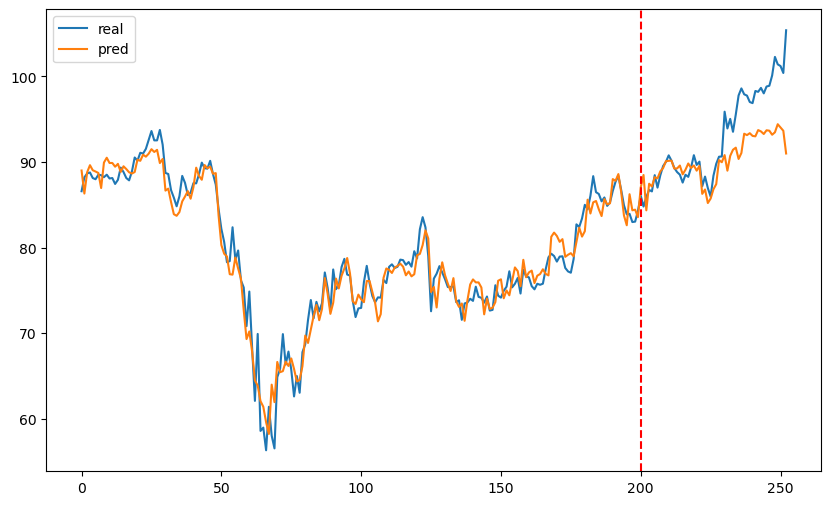

In [56]:
plt.figure(figsize=(10,6))
plt.plot(y)
plt.plot(y_pred)
plt.axvline(x=200, c='r', linestyle='--') 
plt.legend(['real', 'pred'])

- <span style = 'font-size:1.3em;line-height:1.5em'>한번 생각해봅시다. 이런 방식으로 거래량 prediction을 하는게 적합할까요?</span>

    - <span style = 'font-size:1.1em;line-height:1.5em'>현재 이 방법은 daily 시가, 종가 등으로 그 날의 거래량을 예측하는 방식입니다.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>주가 예측이 (혹은 거래량 예측이) 의미가 있으려면, 전날의 해당 주식 상황 등으로 다음날의 종가(혹은 거래량)을 예측하는게 의미 있지 않을까요?</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>즉, $x_{t}$에 (t-1)시점의 주식상황이, $y_t$에 t시점의 거래량이 들어가야 합니다.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>물론, 문제를 어떻게 정의하냐에 따라 이 example처럼 당일 거래량을 추측하는게 목적이 될 수도 있습니다. </span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>그러나, 이 example은 말그대로 RNN계열 모델을 사용하기 위한 예시일 뿐, 실제로 문제에 맞게 모델링 하려면 단순히 이 예시를 따라하지 말고 한번 더 생각을 하셔야 합니다.</span>

# Assignment

<span style = 'font-size:1.3em;line-height:1.5em'>1.위 issue에 대해서 한번 실험을 해봅시다. 다음과 같이 x와 y를 변경하고 실험을 해봅시다.</span>

- <span style = 'font-size:1.2em;line-height:1.5em'>학습 X: df의 index 0부터 198까지의 199일치 ['Open','High','Low','Volume']</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>학습 Y: df의 index 1부터 199까지의 199일치 ['Close']</span>

- <span style = 'font-size:1.2em;line-height:1.5em'>평가 X: df의 index 199부터 251까지의 53일치 ['Open','High','Low','Volume']</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>평가 Y: df의 index 200부터 252까지의 53일치 ['Close']</span>


In [84]:
# data
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].astype(float)
x_cols = ['Open','High','Low','Volume']
y_cols = ['Close']
df_x = df[x_cols]
df_y = df[y_cols]

In [85]:
# 정규화
scaler = StandardScaler()
scaler.fit(df_x)
x = scaler.transform(df_x)

scaler = MinMaxScaler()
scaler.fit(df_y)
y = scaler.transform(df_y)

# train,test split
x_trn, x_tst = x[:199,:], x[199:252,:]
y_trn, y_tst = y[1:200,:], y[200:253,:]

In [86]:
print(len(x_trn), len(y_trn), len(x_tst), len(y_tst))

199 199 53 53


In epoch 100, loss=0.2161
In epoch 200, loss=0.0885
In epoch 300, loss=0.0337
In epoch 400, loss=0.0136
In epoch 500, loss=0.0064
In epoch 600, loss=0.0041
In epoch 700, loss=0.0034
In epoch 800, loss=0.0030
In epoch 900, loss=0.0027
In epoch 1000, loss=0.0025


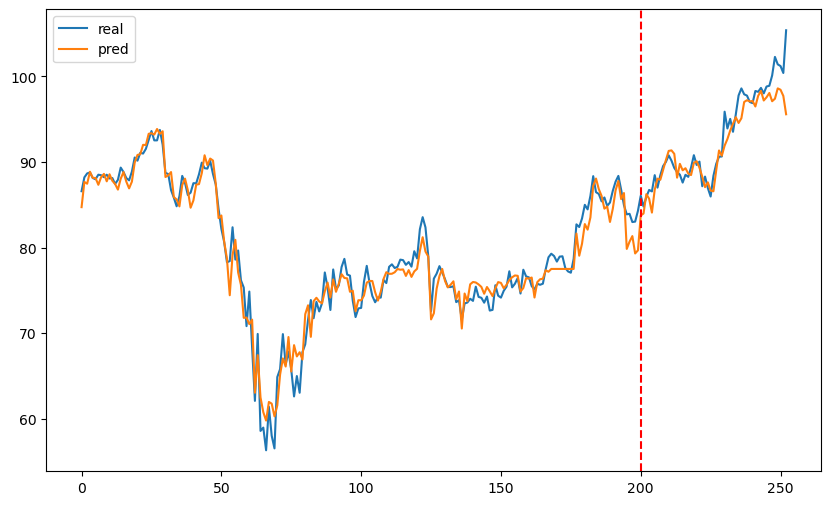

In [87]:
# numpy to tensor
x_trn, y_trn = torch.Tensor(x_trn), torch.Tensor(y_trn)
x_tst, y_tst = torch.Tensor(x_tst), torch.Tensor(y_tst)

x_trn = torch.unsqueeze(x_trn, 1) # x_trn = torch.reshape(x_trn, (x_trn.shape[0], 1, x_trn.shape[1]))
x_tst = torch.unsqueeze(x_tst, 1) # x_tst = torch.reshape(x_trn, (x_tst.shape[0], 1, x_tst.shape[1]))

# hyperparameter setting
num_epochs = 1000
lr = 0.0001

input_size = 4 # Input data에는 총 4개의 column
hidden_size = 5 # hidden layer의 neuron 수
num_layers = 1 # RNN 계층의 수

n_classes = 1
loss_func = nn.MSELoss()

# model & optimizer 
model_rnn = MyRNN(n_classes=n_classes, 
                  input_size=input_size, 
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  seq_len = x_trn.shape[1])
rnn_opt = optim.Adam(params = model_rnn.parameters(), lr = lr)

# train
for epoch in range(num_epochs):
    output = model_rnn.forward(x_trn)
    rnn_opt.zero_grad()
    loss = loss_func(output, y_trn)
    loss.backward()
    rnn_opt.step()
    if (epoch+1) % 100 == 0:
        print(f'In epoch {epoch+1}, loss={loss.item():.4f}')
        
# 정규화
scaler = StandardScaler()
scaler.fit(df_x)
x = scaler.transform(df_x)

scaler = MinMaxScaler()
scaler.fit(df_y)
y = scaler.transform(df_y)

x, y = torch.Tensor(x), torch.Tensor(y)
x = torch.unsqueeze(x, 1) 

# inference
y_pred = model_rnn.forward(x)

y = y.detach().cpu().numpy()
y_pred = y_pred.detach().cpu().numpy()

y = scaler.inverse_transform(y)
y_pred = scaler.inverse_transform(y_pred)

# plotting
plt.figure(figsize=(10,6))
plt.plot(y)
plt.plot(y_pred)
plt.axvline(x=200, c='r', linestyle='--') 
plt.legend(['real', 'pred'])